In [1]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM
from sklearn.cluster import KMeans

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x102076018>>

In [22]:
kernel = 1.0 * RationalQuadratic(length_scale=0.999, alpha=136.)
# for floor in range(0,5):
#     for building in range(0,3):
for floor in range(2,3):
    for building in range(0,1):
        
        ## Count the number of data points in building id & floor id
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num += 1
        print(data_num)
        ## if there are no data, continue to next floor 
        if (data_num == 0):
            continue
            
        ## Load data points in
        wifi_loc_time = np.zeros(shape = (data_num, 524))
        i=-1
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        
        ## Sort by time stamp
        wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]
        
        ## List all users
        user_list = np.unique(wifi_loc_time[:, 522])
        user_num = len(user_list)
        print("On floor ", floor, " in building ", building, "there are ", user_num, " users.")
        
        ## Record each user's number of location logs
        user_walking_num = np.zeros(shape=(user_num), dtype=int)
        for i in range(len(wifi_loc_time[:,522])):
            for user_index in range(user_num):
                if (wifi_loc_time[i, 522] == user_list[user_index]):
                    user_walking_num[user_index] += 1
        
        ## set the sequence length of observed walking tracks
        seq_window = 9
        total_batch_num = 0
        
        ## compute all users' walking sequences and add them as number of batches
        for num in user_walking_num:
            total_batch_num += math.floor(num/seq_window)
        print("total_batch_num: ",total_batch_num)
        
        batch_wifi = np.zeros((total_batch_num, seq_window, 520))
        batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
        ## tracking parameters
        state_count = 0
        ## cumulative graduation [# of batch of user1] + [# of batch of user2] [...]
        batch_num = 0
        iter_batch = 0
        iter_window = 0
        state_map_grid = {}
        
        ## Clustering K-means
        grids = 2
        kmeans = KMeans(n_clusters = grids, random_state=0).fit(wifi_loc_time[:, 520:522])
        centers = kmeans.cluster_centers_
        states = np.zeros(shape=(grids,1), dtype=int)
        
        for i in range(grids):
            states[i] = -1

        for k in range(len(user_list)):
            print("User",k, " walking ", user_walking_num[k])
            
            ## [longitude, latitude, wifi]
            user_fp = np.zeros((user_walking_num[k], 2+520))
            batch_num += math.floor(user_walking_num[k]/seq_window)
            
            ## pick out the corresponding user's data
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    batch_wifi[iter_batch][iter_window] = np.array(wifi_loc_time[i, :520])
                    if (states[kmeans.labels_[i]] == -1):
                        gp = GaussianProcessRegressor(kernel=kernel,
                                          alpha=0.5)
                        states[kmeans.labels_[i]] = state_count
                        grid_wifi_data = batch_wifi[iter_batch][iter_window]
                        grid_loc_data = np.array([wifi_loc_time[i, 520] - centers[kmeans.labels_[i], 0]\
                                                  , wifi_loc_time[i, 521] - centers[kmeans.labels_[i], 1] ])
                        state_map_grid[state_count] = [gp, grid_wifi_data, grid_loc_data]
                        state_count += 1
                    else:
                        state_map_grid[int(states[kmeans.labels_[i]])][1] = np.vstack((state_map_grid[int(states[kmeans.labels_[i]])][1], batch_wifi[iter_batch][iter_window]))
                        state_map_grid[int(states[kmeans.labels_[i]])][2] = np.vstack((state_map_grid[int(states[kmeans.labels_[i]])][2], \
                                   np.array([wifi_loc_time[i, 520] - centers[kmeans.labels_[i], 0]\
                                             , wifi_loc_time[i, 521] - centers[kmeans.labels_[i], 1]] )))
                        
                    batch_loc[iter_batch,iter_window] = states[kmeans.labels_[i]]
                
                    if (iter_window == (seq_window-1)):
                        iter_window = 0
                        iter_batch = iter_batch + 1
                        if (iter_batch == (batch_num)):
                            break
                    else:
                        iter_window = iter_window + 1                
                    
                
        print("# of grids is ", grids, " ; the # of states is ", state_count)
        for s in range(state_count):
            print("State ", s, "; data points: ", state_map_grid[s][2].shape)
            state_map_grid[s][0] = state_map_grid[s][0].fit(state_map_grid[s][1], state_map_grid[s][2])
                    
################## Testing #####################################################################################
        # extract data
        print("Validation...")
        data_num_v = 0
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1
        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i += 1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])
                
        wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]  
                
        batch_num = int(data_num_v/seq_window)
        print("Validating data ", batch_num)
        batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
        batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

        iter_window = 0
        iter_batch = 1

        ## Clustering data points by their longitude & latitude ##
        for s in range(len(wifi_loc_time_v)):
            state_pred = kmeans.predict(wifi_loc_time_v[s][520:522].reshape(1,2))
            batch_loc_v[iter_batch,iter_window] = states[state_pred[0]]
            
            batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[s][:520]
            if (iter_window == (seq_window-1)):
                iter_window = 0
                iter_batch = iter_batch + 1
                if (iter_batch == (batch_num)):
                    break
            else:
                iter_window = iter_window + 1
                
        model = ChainCRF()
        ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=80)            
        ssvm.fit(batch_wifi, batch_loc)
        
        pred_batch_v = ssvm.predict(batch_wifi_v)
        total_error = 0

        center_longitude_pred = 0
        center_latitude_pred = 0
        center_longitude_gt = 0
        center_latitude_gt = 0
        
        real_longitude = 0
        real_latitude = 0

        iter_test = 0
        
        window = np.zeros((seq_window))
        
        error_list = []
        result_lo = []
        result_la = []
        
        gp_total_error = 0
        gp_window = np.zeros((seq_window))
        
        for i in range(1,batch_num+1):
            for j in range(seq_window):
                ans = state_map_grid[int(states[pred_batch_v[i][j]])][0].predict(batch_wifi_v[i][j].reshape(1,520))
                
                center_longitude_pred = centers[states[pred_batch_v[i][j]], 0]
                center_latitude_pred = centers[states[pred_batch_v[i][j]], 1]
                center_longitude_gt = centers[states[batch_loc_v[i][j]], 0]
                center_latitude_gt = centers[states[batch_loc_v[i][j]], 1]
                
                print("\nGrid box: ", i, j)
                print("Predict grid ", states[pred_batch_v[i][j]], "; Gt grid ", states[batch_loc_v[i][j]])
                print("longitude ", center_longitude_pred, center_longitude_gt)
                print("latitude ", center_latitude_pred, center_latitude_gt)
                
                print(ans[0][0], ans[0][1])
                print("Add...")
                ans[0][0] += center_longitude_pred
                ans[0][1] += center_latitude_pred
                result_lo.append(ans[0][0])
                result_la.append(ans[0][1])
                real_longitude = wifi_loc_time_v[iter_test][520]
                real_latitude = wifi_loc_time_v[iter_test][521]
                print("predict: ", ans[0][0], ans[0][1])
                print("real: ", real_longitude, real_latitude)
                print("RMSE: ", math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2)))
                error_list.append(math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2)))
                gp_total_error += math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2))
                gp_window[j] += math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2))
                
                iter_test+=1
                
                total_error += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                            
                window[j] += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                

        print("\nbox\nRMSE: ", total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, window[x]/batch_num)
        print("gp")
        print("RMSE: ", gp_total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, gp_window[x]/batch_num)
        print("Finish\n")

1443
On floor  2  in building  0 there are  2  users.
total_batch_num:  159
User 0  walking  733
User 1  walking  710
# of grids is  2  ; the # of states is  2
State  0 ; data points:  (687, 2)
State  1 ; data points:  (744, 2)
Validation...
165
Validating data  18

Grid box:  1 0
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
8.961042736474155 12.314198966710137
Add...
predict:  -7647.924811960378 4864938.796204313
real:  -7637.418826227427 4864955.693250269
RMSE:  19.896881621498128

Grid box:  1 1
Predict grid  [1] ; Gt grid  [1]
longitude  [-7622.42638037] [-7622.42638037]
latitude  [4864987.98787121] [4864987.98787121]
26.7642537826232 -4.677535111094585
Add...
predict:  -7595.6621265910235 4864983.310336103
real:  -7589.066216434082 4864985.332244752
RMSE:  6.898851019142924

Grid box:  1 2
Predict grid  [1] ; Gt grid  [1]
longitude  [-7622.42638037] [-7622.42638037]
latitude  [4864987.98787121] [4864987

latitude  [4864926.48200535] [4864926.48200535]
-16.28216253699611 4.325305016328457
Add...
predict:  -7673.168017233848 4864930.807310362
real:  -7676.753699999303 4864934.623499997
RMSE:  5.236451491402259

Grid box:  4 6
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-21.362618058919907 3.9862839258112217
Add...
predict:  -7678.248472755772 4864930.468289271
real:  -7676.753699999303 4864934.623499997
RMSE:  4.415894220952576

Grid box:  4 7
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-20.419123854042482 4.468867876024888
Add...
predict:  -7677.304978550895 4864930.950873221
real:  -7676.617487958357 4864933.595861311
RMSE:  2.7328749166420505

Grid box:  4 8
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-11.1357936420045 3.0382466525352356
Add...
pred


Grid box:  8 2
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
4.9470135230385495 -0.5988063607255754
Add...
predict:  -7651.938841173814 4864925.883198985
real:  -7653.343301445246 4864920.963251496
RMSE:  5.1164823805198205

Grid box:  8 3
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
4.693373889253053 -0.33540901880951424
Add...
predict:  -7652.192480807599 4864926.1465963265
real:  -7653.343301445246 4864920.963251493
RMSE:  5.309562298678881

Grid box:  8 4
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
10.0977961132985 -3.5918934808250924
Add...
predict:  -7646.788058583554 4864922.890111865
real:  -7652.241956907715 4864922.759256407
RMSE:  5.455467906709433

Grid box:  8 5
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
la


Grid box:  11 8
Predict grid  [1] ; Gt grid  [1]
longitude  [-7622.42638037] [-7622.42638037]
latitude  [4864987.98787121] [4864987.98787121]
-13.735702532827418 6.95136720718574
Add...
predict:  -7636.162082906474 4864994.939238421
real:  -7638.910299999018 4865000.254833335
RMSE:  5.983999204664069

Grid box:  12 0
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
4.2664109232919145 6.28303698061336
Add...
predict:  -7652.61944377356 4864932.765042326
real:  -7642.797866873924 4864924.111738862
RMSE:  13.089806478732823

Grid box:  12 1
Predict grid  [1] ; Gt grid  [1]
longitude  [-7622.42638037] [-7622.42638037]
latitude  [4864987.98787121] [4864987.98787121]
4.198401863639447 -5.928760582619816
Add...
predict:  -7618.227978510007 4864982.059110631
real:  -7616.948850388485 4864979.692616927
RMSE:  2.690067136965561

Grid box:  12 2
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
l


Grid box:  15 5
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-5.320776930966531 5.478851232463057
Add...
predict:  -7662.206631627819 4864931.960856578
real:  -7673.435291772968 4864934.636708568
RMSE:  11.54309284919705

Grid box:  15 6
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-18.25848178961769 6.428565738655379
Add...
predict:  -7675.14433648647 4864932.910571084
real:  -7684.867957990277 4864930.973256281
RMSE:  9.91473669836914

Grid box:  15 7
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude  [4864926.48200535] [4864926.48200535]
-20.163037366644858 6.62663831478676
Add...
predict:  -7677.048892063497 4864933.10864366
real:  -7690.500866667678 4864927.699600001
RMSE:  14.4987369815933

Grid box:  15 8
Predict grid  [0] ; Gt grid  [0]
longitude  [-7656.8858547] [-7656.8858547]
latitude

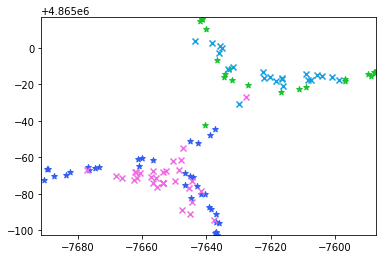

In [24]:
color = ['#da2614', '#b7e020', '#f16ce5', '#169fe3', '#2f5cf4', '#17C32C', '#0626EF', '#E579B1']
axes = plt.gca()
axes.set_xlim([min(wifi_loc_time[:,520]),max(wifi_loc_time[:,520])])
axes.set_ylim([min(wifi_loc_time[:,521]),max(wifi_loc_time[:,521])])
# for i in range(len(wifi_loc_time)):    
#     plt.scatter(wifi_loc_time[i,520], wifi_loc_time[i,521], c=color[kmeans.labels_[i]], marker='o')
for j in range(len(error_list)):
    pred = kmeans.predict(wifi_loc_time_v[j][520:522].reshape(1,2))
    if (error_list[j] > 10):
        plt.scatter(wifi_loc_time_v[j,520], wifi_loc_time_v[j,521], c=color[4+pred[0]], marker='*')
        plt.scatter(result_lo[j], result_la[j], c=color[2+pred[0]], marker='x')
#     else:
#         plt.scatter(wifi_loc_time_v[j,520], wifi_loc_time_v[j,521], c=color[2+pred[0]], marker='^')
plt.show()